# Drought Network: Filter & Mapping

a. stein

8.16.2022

This notebook delves into the `DroughtNetwork` class developed in `explore/drought_event_network` and `explore/network_refinement`. Here I look into filtering by area to reduce noise (and disconnecting appropriate events where needed due to filter), adding a few more plot coloring, and converting the DroughtNetwork back out into an image.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_275373/2338660029.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Setup test cases

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

### 5x5 bounded grid (hard-coded)

In [3]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
ca_matrix_5x5 = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

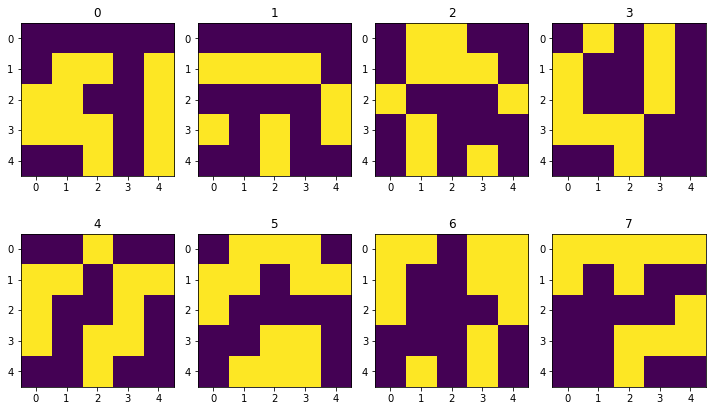

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

ca_series_5x5 = []
plot_matrix = ca_matrix_5x5

for i, ax in enumerate(axs.ravel()):
    ca_series_5x5.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_5x5 = np.array(ca_series_5x5)

plt.tight_layout()

In [5]:
ca_net_5x5 = dnet.DroughtNetwork(ca_series_5x5, name="5x5 Cellular Automata")

  0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
node_12 = ca_net_5x5.find_node_by_id(12)
node_12

time: 6, id: 12

In [7]:
node_12.future

[time: 7, id: 14, time: 7, id: 15]

In [8]:
node_12.get_future_thread()

[time: 6, id: 12, time: 7, id: 14, time: 7, id: 15]

In [9]:
ca_net_5x5.find_node_by_id(5).get_future_thread()

[time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 6, id: 12,
 time: 7, id: 15,
 time: 5, id: 10,
 time: 6, id: 13]

In [10]:
node_12.get_future_thread()

[time: 6, id: 12, time: 7, id: 14, time: 7, id: 15]

In [11]:
node_12.future

[time: 7, id: 14, time: 7, id: 15]

In [12]:
ca_net_5x5.find_node_by_id(6).get_future_thread()

[time: 2, id: 6]

In [13]:
ca_net_5x5.find_node_by_id(9).get_future_thread()

[time: 5, id: 9,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 6, id: 12,
 time: 7, id: 15]

In [14]:
ca_net_5x5.find_node_by_id(6).get_future_thread()

[time: 2, id: 6]

## Network to array

In [15]:
print(ca_net_5x5)

5x5 Cellular Automata: DroughtNetwork with D1 threshold, spawned 29-08-2022 11:01:14


In [16]:
coords_0 = ca_net_5x5.nodes[0].coords
coords_0

array([[1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [3, 0],
       [3, 1],
       [3, 2],
       [4, 2]])

In [17]:
remap_test = np.zeros((5,5))

for coord in coords_0:
    i, j = coord
    remap_test[i, j] +=1 

remap_test

array([[0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

That was ... surprisingly simple. Can I now plot out a series for a single drought origin?

In [18]:
thread_0 = ca_net_5x5.get_chronological_future_thread(id=0)

remap_ts = np.zeros((8, 5,5))

for node in thread_0:
    t = node.time
    for coord in node.coords:
        i, j = coord
        remap_ts[t, i, j] += 1

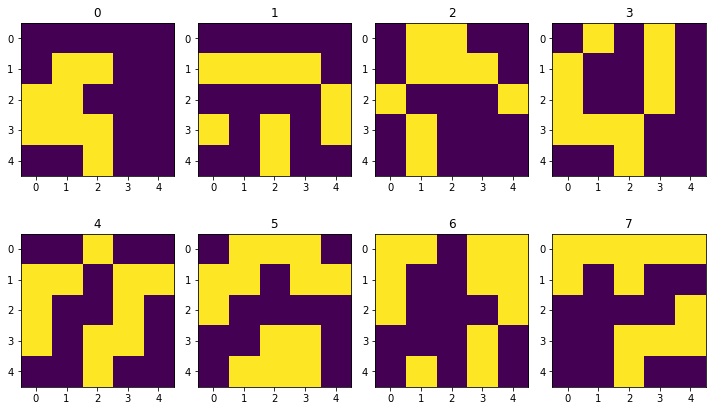

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(remap_ts[i, :, :])
    ax.set_title(i)

plt.tight_layout()

Fabulous. So we can see at time 0, the drought event 1 is not plotted and at time 2, drought event 6 is not plotted, showing only what came from drought event 0. 

Let's wrap this into a function

In [20]:
# check that if we don't do any selecting, we get the original data
np.where(ca_net_5x5.to_array() != ca_series_5x5)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [21]:
# check that if we don't do any selecting, we get the original data
np.where(ca_net_5x5.to_array(id=0) != remap_ts)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

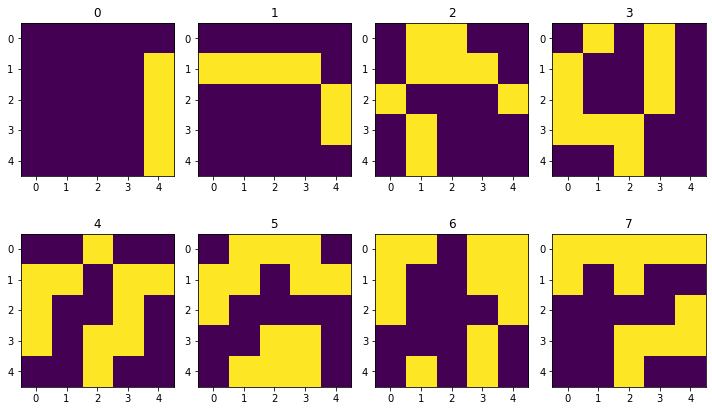

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

func_reamp_ts = ca_net_5x5.to_array(id=1)

for i, ax in enumerate(axs.ravel()):
    ax.imshow(func_reamp_ts[i, :, :])
    ax.set_title(i)

plt.tight_layout()



In [23]:
ca_net_5x5.find_node_by_id(5).get_future_thread()

[time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 6, id: 11,
 time: 7, id: 14,
 time: 6, id: 12,
 time: 7, id: 15,
 time: 5, id: 10,
 time: 6, id: 13]

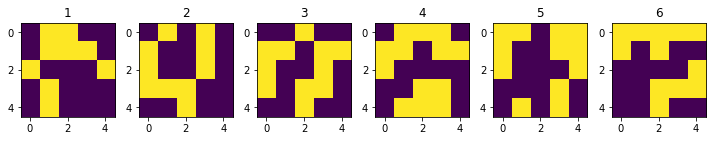

In [24]:
fig, axs = plt.subplots(1, 6, figsize=(10,6))

func_reamp_ts = ca_net_5x5.to_array(id=5)

for i, ax in enumerate(axs.ravel()):
    ax.imshow(func_reamp_ts[i, :, :])
    ax.set_title(i+1)

plt.tight_layout()



Cool, that works. Had to move `get_future_thread` to `DroughtNetwork` for some reason but it now works.

### Color by Time

Wrote the function real quick in the script, let's check that it works

In [25]:
topog, pos = ca_net_5x5.get_nx_network()

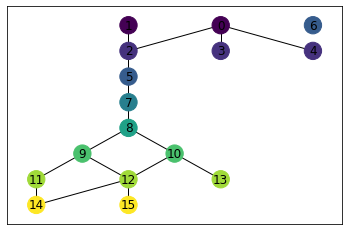

In [26]:
fig, ax = plt.subplots()

nx.draw_networkx(topog, pos, node_color = ca_net_5x5.temporal_color_map(), ax=ax)

Yup. Nice

## Filter

So here I want to not only be able to filter by an area parameter ... but also break up groups if need be as a post-processing step

I wasn't having much luck trying to find parameters to find what is too small for a drought ... beyond Diaz et. al 2019 just having a floor to discriminate against small clusters. They also link their clusters just be what's largest and centroid proximity, whereas I'm doing if they have touching cells between each other ... assuming that the speed at which a drought moves in a time step (5-7 days) is less than the size of the cells (given droughts, except flash drought, is not a quick resolving phenomenon typically, I think this assumption is fine). Now I could apply this floor logic and let areas of only one or two cells be tossed. But this feels like it'd be biased then against small, localized droughts. I think a better attempt might be to evaluate exactly how many cells are shared between time steps and put a % threshold that must be exceed for it to be considered still the same drought event. I feel like this would help disconnect events that are just hanging on by a few cells? My thinking behind this is that droughts typically shrink rather than just being suddenly withdrawn. Now this might also screw up and cut droughts off early too ... 

Now to actually test something like this ... I do need to use actual data because the cellular automata that I checked is def too small. And doing a 15 by 15 doesn't sound like a worthwhile time ...

I think the `spi_5y` would be a good candidate for this

In [ ]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [ ]:
spi_5y_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/spi/WA/spi_5y_net.pickle')

In [ ]:
og_ids = [node.id for node in spi_5y_net.nodes]

In [ ]:
og_adj_mat = spi_5y_net.adj_mat

topog = dnet.DroughtNetwork.unpickle(f'{dm_path}/spi/WA/spi_WA_nx.pickle')[0]['5y']
pos = dnet.DroughtNetwork.unpickle(f'{dm_path}/spi/WA/spi_WA_nx.pickle')[1]['5y']

fig, ax = plt.subplots()

nx.draw_networkx(topog, pos)

In [ ]:
areas = []
for node in spi_5y_net.nodes:
    areas.append(node.area)
areas.sort()
areas = np.array(areas)

In [ ]:
ranks = np.arange(1,len(areas)+1,1)
positions = (ranks-0.4)/(len(areas)+0.2)

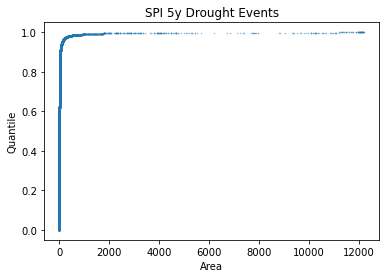

In [ ]:
fig, ax = plt.subplots()

ax.scatter(areas, positions, marker='.', s=1, alpha=0.5)
ax.set_xlabel('Area')
ax.set_ylabel('Quantile')
ax.set_title('SPI 5y Drought Events');

So I'm not seeing a great lower bound tbh

In [ ]:
num_events = []
floor_area = np.arange(12000)

for i in floor_area:
    num_events.append(len(areas[areas>i]))
num_events = np.array(num_events)

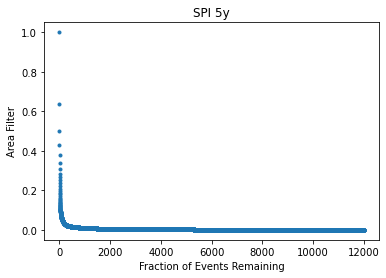

In [ ]:
fig, ax = plt.subplots()

ax.scatter(floor_area, num_events/len(areas), marker='.')
ax.set_ylabel('Area Filter')
ax.set_xlabel('Fraction of Events Remaining')
ax.set_title('SPI 5y');

Okay, let's see what happens if we make the filter 1 pixel

First I want to color the plot by which nodes I'd be filtering

filter_map = []

for node in spi_5y_net.nodes:
    filter_map.append((int(node.area==1), 0, 0))

fig, ax = plt.subplots(figsize=(30,30))

nx.draw_networkx(topog, pos, node_color=filter_map, ax=ax, node_size=1, with_labels=False)

That looks likes some cyberpunk evil code thing. Looks like it'll actually split things up a lot.

So to do a filter, I need to do the following:
- remove node from tree & nodes list
- remove node from futures of nodes pointing to it
- remove node from pasts of nodes pointing from it
- any node in it's future needs to become and origin

Now if I don't destroy the node, but instead toss it into some sort of `filtered_nodes` list, then the operation would also be reversible

In [ ]:
filter = 1

filtered_nodes = []

for node in spi_5y_net.nodes:
    if node.area == filter:
        filtered_nodes.append(node)

for node in tqdm(filtered_nodes):
    try:
        spi_5y_net.nodes.remove(node)
        spi_5y_net.origins.remove(node)
    except:
        pass

    past_nodes = node.past
    future_nodes = node.future

    for past_node in past_nodes:
        past_node.future.remove(node)
    
    for future_node in future_nodes:
        future_node.past.remove(node)
        if len(future_node.past) == 0 and not future_node in spi_5y_net.origins:
            spi_5y_net.origins.append(future_node)

  0%|          | 0/15069 [00:00<?, ?it/s]

In [ ]:
len(filtered_nodes)

15069

In [ ]:
len(spi_5y_net.nodes)

26410

In [ ]:
len(filtered_nodes)+len(spi_5y_net.nodes)

41479

So that looks like it removed them ...

In [ ]:
spi_5y_net.adj_mat.shape

(41479, 41479)

In [ ]:
adj_mat_filtered = np.zeros((41479, 41479))

for node in tqdm(spi_5y_net.nodes):
    i_id = node.id
    for future in node.future:
        j_id = future.id
        adj_mat_filtered[i_id, j_id] = 1

  0%|          | 0/26410 [00:00<?, ?it/s]

In [ ]:
spi_5y_net.adj_mat = adj_mat_filtered

topog, pos = spi_5y_net.get_nx_network()

fig, ax = plt.subplots(figsize=(30,30))

nx.draw_networkx(topog, pos, ax=ax, node_size=1, with_labels=False)

Interesting ...

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

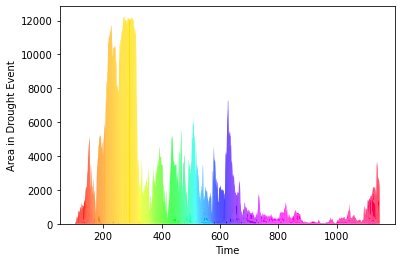

In [ ]:
spi_5y_net.stacked_events_plot()

Well that works. What filter is most significant idk yet

Let's put that into a function, then work on an "undo"

In [ ]:
for node in tqdm(filtered_nodes):
    
    if len(node.past) > 0:
        for past_node in node.past:
            past_node.future.append(node)
    else:
        spi_5y_net.origins.append(node)
    
    for future_node in node.future:
        
        future_node.past.append(node)
        if future_node in spi_5y_net.origins:
            spi_5y_net.origins.remove(future_node)
    # lastly need to put the node back in order
    # since some of the code relies on them being ordered
    i = 0
    node_placed=False
    while i < len(spi_5y_net.nodes) and not node_placed:
        if node.id > spi_5y_net.nodes[i].id:
            i += 1
        else:
            spi_5y_net.nodes.insert(i, node)
            node_placed = True
    # now we could get through the whole list
    # and not end up placing the node cause it should
    # go at the end, so let's catch that
    if not node_placed:
        spi_5y_net.nodes.append(node)

  0%|          | 0/15069 [00:00<?, ?it/s]

In [ ]:
spi_5y_net.rebuild_adj_mat()

  0%|          | 0/41479 [00:00<?, ?it/s]

In [ ]:
len(spi_5y_net.nodes)

41479

That's looking promising, is the figure the same?

topog, pos = spi_5y_net.get_nx_network()

fig, ax = plt.subplots(figsize=(30,30))

nx.draw_networkx(topog, pos, ax=ax, node_size=1, with_labels=False)

Wooot!

Let's double check putting the nodes back in the right order worked out

In [ ]:
ids = [node.id for node in spi_5y_net.nodes]
ids_sorted = ids.copy()
ids_sorted.sort()

In [ ]:
ids == ids_sorted

True

In [ ]:
ids == og_ids

True

In [ ]:
ids_sorted == og_ids

True

Cool, so our list of nodes is in the right order, but did our connections all get matched up? Let's check adjacency matrix equivalency

In [ ]:
np.where(og_adj_mat != spi_5y_net.adj_mat)

(array([], dtype=int64), array([], dtype=int64))

So that looks good ... now i should be able to effectively repeat the process if I have the same network, right?

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'
spi_5y_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/spi/WA/spi_5y_net.pickle')

In [3]:
len(spi_5y_net.nodes)

41479

In [4]:
filtered_nodes = spi_5y_net.network_filter_by_area(1)

  0%|          | 0/15069 [00:00<?, ?it/s]

time: 99, id: 0, futures: []

time: 101, id: 1, futures: []

time: 103, id: 2, futures: [8]
[time: 104, id: 8]

time: 104, id: 3, futures: [9]
[time: 105, id: 9]

time: 104, id: 5, futures: []

time: 104, id: 6, futures: [12]
[time: 105, id: 12]

time: 104, id: 7, futures: [13]
[time: 105, id: 13]

time: 105, id: 9, futures: [17]
[time: 106, id: 17]

time: 105, id: 12, futures: [22]
[time: 106, id: 22]

time: 105, id: 13, futures: [23]
[time: 106, id: 23]

time: 105, id: 14, futures: []

time: 105, id: 16, futures: [25]
[time: 106, id: 25]

time: 106, id: 22, futures: [28]
[time: 107, id: 28]

time: 106, id: 25, futures: [30]
[time: 107, id: 30]

time: 107, id: 29, futures: []

time: 107, id: 31, futures: []

time: 108, id: 33, futures: [39]
[time: 109, id: 39]

time: 109, id: 41, futures: []

time: 109, id: 42, futures: []

time: 109, id: 44, futures: []

time: 109, id: 45, futures: []

time: 109, id: 46, futures: []

time: 109, id: 47, futures: []

time: 109, id: 48, futures: []

tim

In [5]:
len(spi_5y_net.nodes)

26410

In [6]:
len(filtered_nodes)

15069

In [7]:
spi_5y_net.insert_nodes_in_network(filtered_nodes)

  0%|          | 0/15069 [00:00<?, ?it/s]

In [8]:
len(spi_5y_net.nodes)

41479

In [11]:
filtered_nodes = spi_5y_net.network_filter_by_area(1)

  0%|          | 0/15063 [00:00<?, ?it/s]

time: 104, id: 7, futures: [13, 13]
[time: 105, id: 13, time: 105, id: 13]
[time: 105, id: 13, time: 105, id: 13]


ValueError: list.remove(x): x not in list

spi_5y_net.insert_nodes_in_network(filtered_nodes)

In [ ]:
len(spi_5y_net.nodes)

26411

Okay, so one thing I was eventually noticing was that filtered nodes could be pointing to each other. They would all get removed, but then when they're added back in there are missing connections. Additionally, if a node is removed that's filtered before what it points to is removed, then can end up with duplicate past/future or missing them all together.

So I'm shifting to instead change what adjacency matrix is generated and what is plotted from there.

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'
spi_5y_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/spi/WA/spi_5y_net.pickle')

In [3]:
topog, pos = spi_5y_net.filter_graph_by_area(1)

  0%|          | 0/41479 [00:00<?, ?it/s]

  0%|          | 0/15069 [00:00<?, ?it/s]

In [7]:
len(topog.nodes)

26410

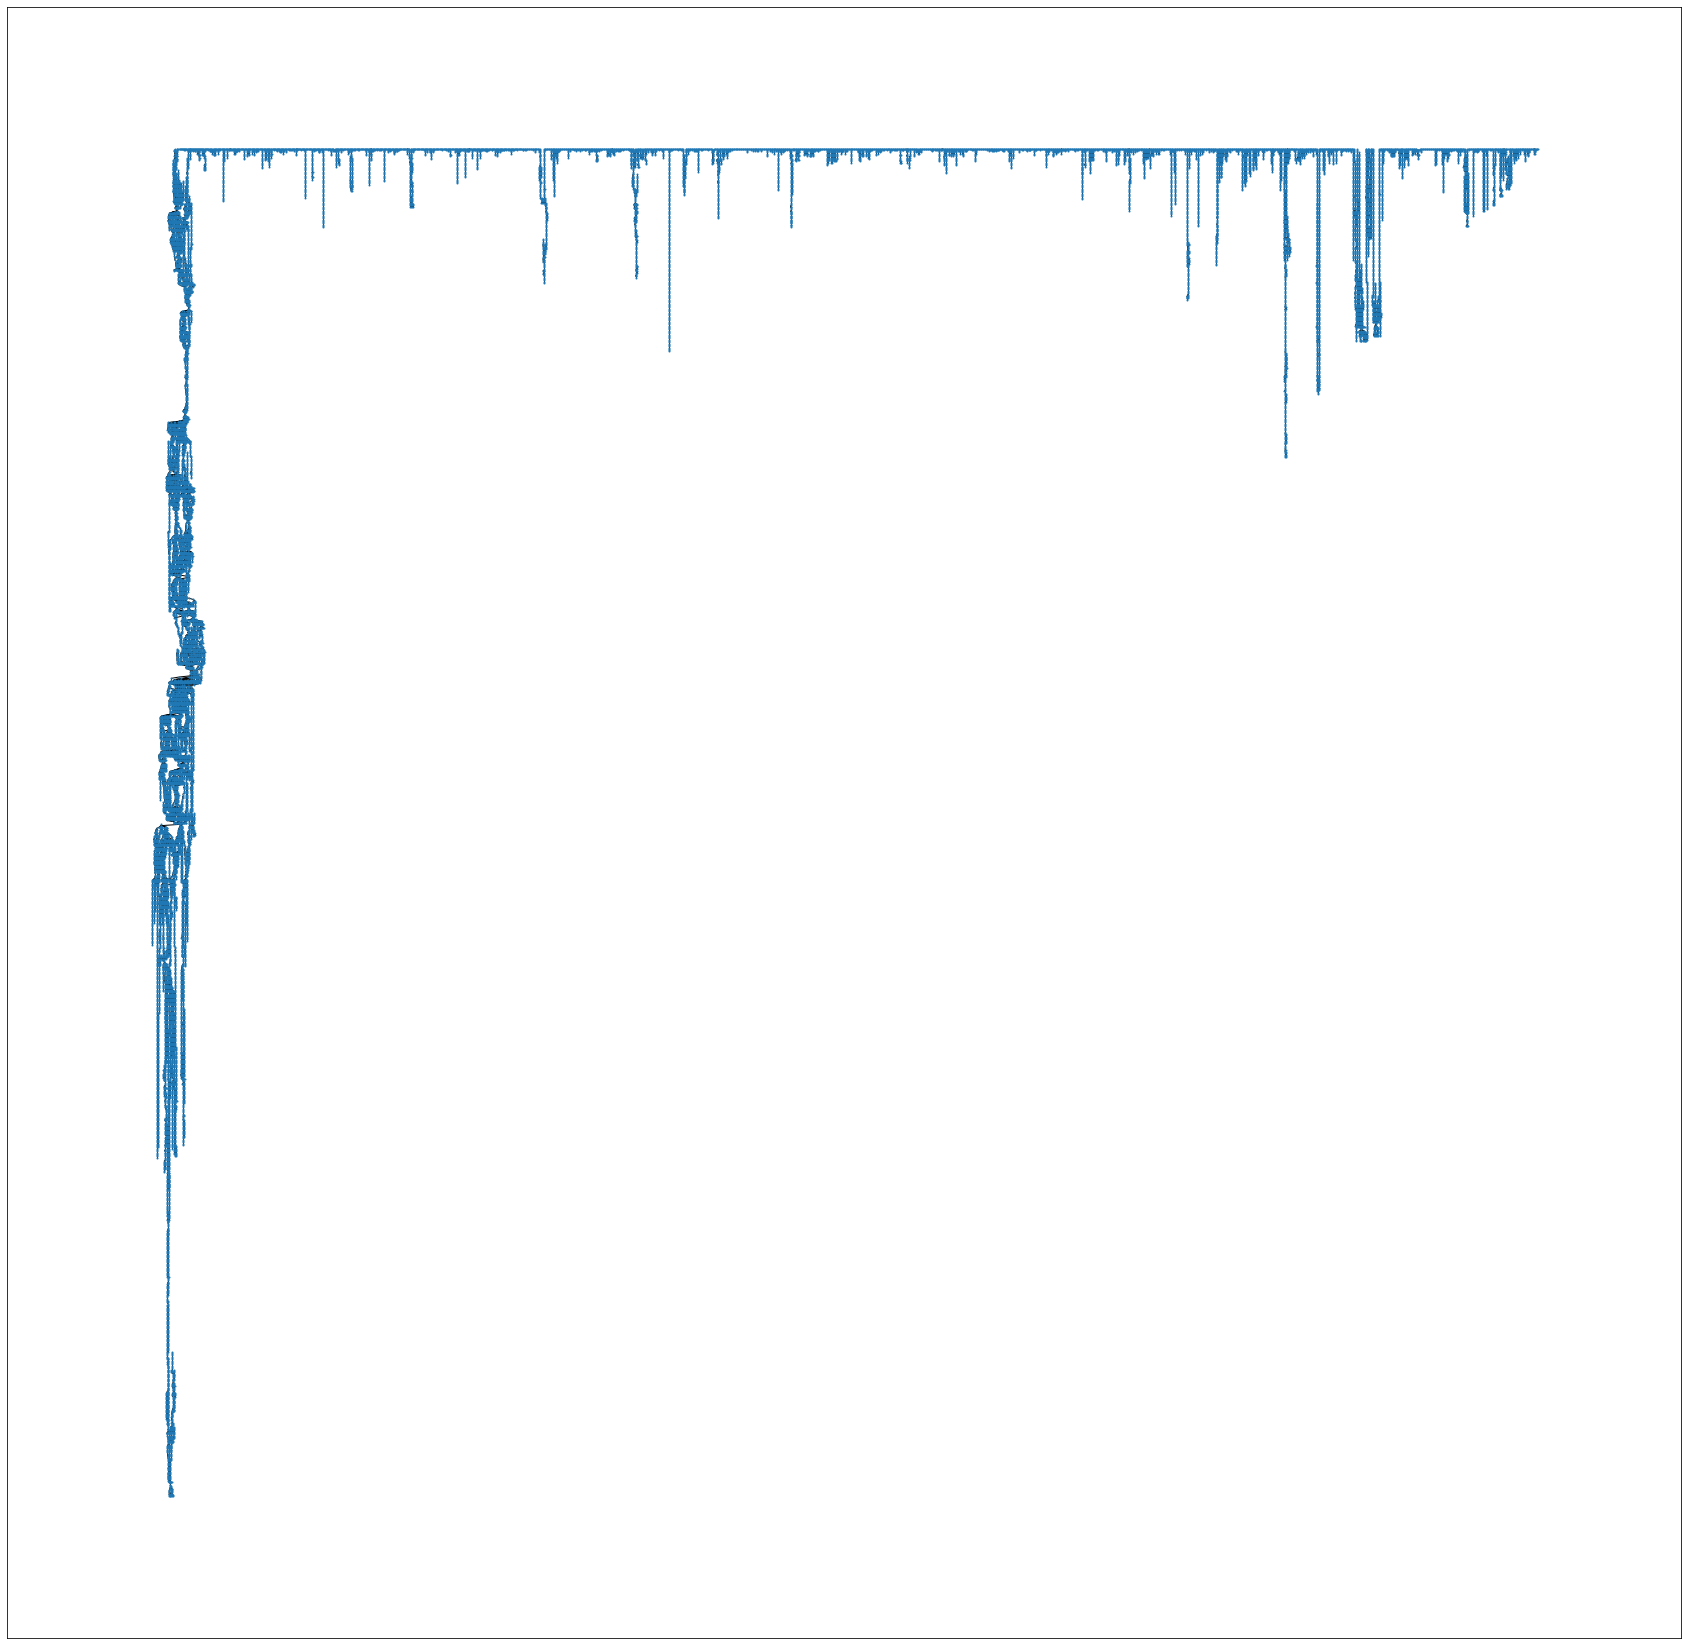

In [8]:
fig, ax = plt.subplots(figsize=(30,30))

nx.draw_networkx(topog, pos, ax=ax, node_size=1, with_labels=False)

In [27]:
topog, pos = ca_net_5x5.filter_graph_by_area(1)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

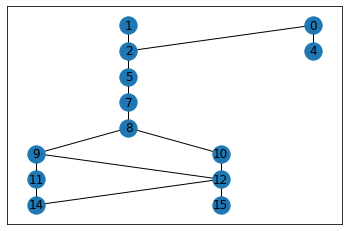

In [31]:
fig, ax = plt.subplots()

nx.draw_networkx(topog, pos, ax=ax, with_labels=True)

Checked this by hand and that's correct!

Now one issue here is that this won't let me apply the filter to data converted out of the graph and into an array. 

### Load in actual data

usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')
usdm_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/usdm/usdm_WA_net.pickle')

intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]

spi = xr.open_dataset(f'{dm_path}/spi/WA/spi_usdmcat_WA.nc')
spi_nets = dict()
for interval in intervals:
    spi_nets[interval] = dnet.DroughtNetwork.unpickle(f'{dm_path}/spi/WA/spi_{interval}_net.pickle')